In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as gnn
import pickle
from tqdm import tqdm
import numpy as np
from torch.functional import F
import matplotlib.pyplot as plt


with open("data/train_graphs_data.pkl", "rb") as file:
    graphs = pickle.load(file)
    file.close()

In [2]:
len(graphs), graphs[0]

(90,
 Data(x=[1140, 33], edge_index=[2, 11709], edge_attr=[11709, 2], y=[1140, 2]))

In [3]:
graphs[0].y[0]

tensor([-0.2741, -0.6940])

In [4]:
# 划分训练集和验证集，使用sklearn的train_test_split函数
from sklearn.model_selection import train_test_split

train_graphs, val_graphs = train_test_split(graphs, test_size=0.1, random_state=42)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv

class GINModel(nn.Module):
    def __init__(self, input_size, output_size, eps=1e-5):  # Adding 'eps' parameter
        super(GINModel, self).__init__()

        self.conv1 = GINConv(nn.Sequential(nn.Linear(input_size, 128), nn.ReLU(), nn.Linear(128, 128)))
        self.ln1 = nn.LayerNorm(128, eps=eps)  # Adding 'eps' to LayerNorm
        self.conv2 = GINConv(nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 128)))
        self.ln2 = nn.LayerNorm(128, eps=eps)  # Adding 'eps' to LayerNorm
        self.conv3 = GINConv(nn.Sequential(nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 128)))
        self.ln3 = nn.LayerNorm(128, eps=eps)  # Adding 'eps' to LayerNorm

        self.regression = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64, eps=eps),  # Adding 'eps' to LayerNorm
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32, eps=eps),  # Adding 'eps' to LayerNorm
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, output_size),
        )

    def forward(self, data):
        x, edge_index, _ = data.x, data.edge_index, data.edge_attr

        x = F.relu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.ln2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.ln3(x)

        output = self.regression(x)

        return output


In [12]:
# 看看模型的输入输出
model = GINModel(input_size=33, output_size=2)
output = model(graphs[0])
output.shape

torch.Size([1140, 2])

In [13]:
input_size = graphs[0].x.shape[1]
# 这里的output_size就是最终的输出维度，不需要再乘以num_heads
output_size = graphs[0].y.shape[1]
# 个人认为，注意力头的个数应该和输出维度保持一致，因为每个输出可能需要关注不同的邻居
num_heads = graphs[0].y.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch_size = 256

# 开始训练

In [14]:
def train(model, criterion, optimizer, train_graphs, val_graphs=None, num_epochs=50):
    # 训练过程记录
    train_loss_list = []
    val_loss_list = []

    with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar_epochs:
        for epoch in range(num_epochs):
            # 训练
            model.train()
            train_loss = 0.0

            # 目前每个batch是1个graph
            for i, graph in enumerate(train_graphs):
                graph = graph.to(device)

                output = model(graph)

                optimizer.zero_grad()
                loss = criterion(output, graph.y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_graphs)
            train_loss_list.append(train_loss)

            # 验证
            if val_graphs:
                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for i, graph in enumerate(val_graphs):
                        graph = graph.to(device)
                        output = model(graph)
                        loss = criterion(output, graph.y)
                        val_loss += loss.item()
                    val_loss /= len(val_graphs)
                    val_loss_list.append(val_loss)

            if val_graphs:
                pbar_epochs.set_postfix(
                    {"train MSE Loss": train_loss, "val MSE Loss": val_loss}
                )
            else:
                pbar_epochs.set_postfix({"train MSE Loss": train_loss})
            pbar_epochs.update(1)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label="train loss")
    if val_graphs:
        plt.plot(val_loss_list, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.legend()

    return model

Training Progress: 100%|████████████████| 200/200 [00:48<00:00,  4.11epoch/s, train MSE Loss=0.442, val MSE Loss=0.701]


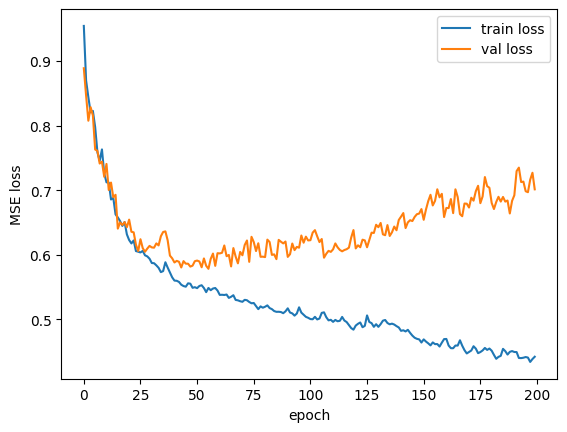

In [15]:
# 定义模型、算法、损失函数
model = GINModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

model = train(
    model, criterion, optimizer, train_graphs, val_graphs, num_epochs=200
)

Training Progress: 100%|████████████████████████████████████| 100/100 [00:26<00:00,  3.72epoch/s, train MSE Loss=0.521]


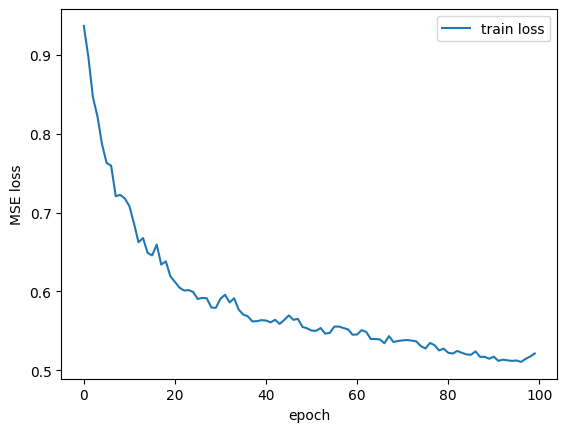

In [16]:
# 定义模型、算法、损失函数
model = GINModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

model = train(model, criterion, optimizer, graphs, num_epochs=100)

In [17]:
# 保存模型
model_path = "saved/models/gin.pth"
torch.save(model.state_dict(), model_path)

# 预测

In [18]:
# 读取模型
model = GINModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [19]:
# 读取node_ids
with open("data/node_ids.pkl", "rb") as file:
    node_ids = pickle.load(file)
    file.close()

In [20]:
# 读取scaler
import pickle

with open("saved/scaler/label_scaler.pkl", "rb") as file:
    label_scaler = pickle.load(file)
    file.close()

D:\conda-python\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
# 读取测试集
with open("data/test_graphs_data.pkl", "rb") as file:
    test_graphs = pickle.load(file)
    file.close()

In [22]:
len(test_graphs), test_graphs[0]

(4, Data(x=[1140, 33], edge_index=[2, 21018], edge_attr=[21018, 2]))

预测

In [23]:
model.eval()
output_list = []
with torch.no_grad():
    for i, graph in enumerate(test_graphs):
        graph = graph.to(device)
        output = model(graph)
        output_list.append(output.detach().cpu().numpy())

In [24]:
len(output_list), output_list[0].shape, output_list[0][0]

(4, (1140, 2), array([-0.50838083, -1.0533646 ], dtype=float32))

In [25]:
# 缩放
output_list = [label_scaler.inverse_transform(output) for output in output_list]

In [26]:
# 看看是不是缩放完成啦
output_list[0][0]

array([68.50164 , 60.660656], dtype=float32)

### 把输出转成需要的格式

In [27]:
import csv

# 结果写入csv，分隔符为\t
output_path = "output/gin_out.csv"

date_id = [20230404, 20230405, 20230406, 20230407]
with open(output_path, "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # 设置分隔符为制表符
    writer.writerow(["geohash_id", "consumption_level", "activity_level", "date_id"])

    # output_list.shape = [4天, 节点数, 2个输出]
    for nidx in range(len(node_ids)):
        for day in range(len(date_id)):
            # 注意不要写反了
            writer.writerow(
                [
                    node_ids[nidx],
                    output_list[day][nidx][1],
                    output_list[day][nidx][0],
                    date_id[day],
                ]
            )
    f.close()